# Model Performance Visualization using Radar Chart

This notebook generates Radar/Spider diagrams to compare the performance of different models across clinical prediction tasks (mortality, AKI, sepsis) and datasets (hirid, miiv, eicu).

In [1]:
# Import Required Libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import os

In [2]:
# Load and Prepare Data
# Load the JSON file
with open("../docs/results.json", "r") as f:
    results_data = json.load(f)

# Extract the results list
results_list = results_data["results"]

# Create a flattened list of dictionaries for DataFrame creation
flattened_results = []
for result in results_list:
    # Create a dictionary for each result
    flat_result = {
        "Model": result["model_id"],
        "Task": result["task_id"],
        "Dataset": result["dataset"]
    }
    
    # Add all metrics from the metrics_summary/overall section
    if "metrics_summary" in result and "overall" in result["metrics_summary"]:
        metrics = result["metrics_summary"]["overall"]
        for metric_key, metric_value in metrics.items():
            flat_result[metric_key] = metric_value
    
    flattened_results.append(flat_result)

# Create DataFrame
df = pd.DataFrame(flattened_results)

print(f"Loaded data with shape: {df.shape}")
print(f"Columns: {', '.join(df.columns)}")
df.head()

Loaded data with shape: (59, 16)
Columns: Model, Task, Dataset, auroc, auprc, normalized_auprc, sensitivity, specificity, f1_score, accuracy, balanced_accuracy, precision, recall, mcc, kappa, minpse


Model       Task Dataset  auroc  auprc  normalized_auprc  \
0  RandomForest  mortality   hirid  0.902  0.614             5.580   
1  RandomForest  mortality    miiv  0.823  0.652             5.434   
2  RandomForest  mortality    eicu  0.773  0.469             6.705   
3  RandomForest        aki   hirid  0.741  0.270             3.051   
4  RandomForest        aki    miiv  0.835  0.526             4.124   

   sensitivity  specificity  f1_score  accuracy  balanced_accuracy  precision  \
0        0.182        1.000     0.308     0.910              0.591      1.000   
1        0.000        1.000     0.000     0.880              0.500      0.000   
2        0.143        1.000     0.250     0.940              0.571      1.000   
3        0.008        1.000     0.016     0.912              0.504      1.000   
4        0.092        0.999     0.167     0.883              0.545      0.936   

   recall    mcc  kappa  minpse  
0   0.182  0.406  0.283   0.500  
1   0.000  0.000  0.000   0.667  
2   0.143  0.366  0.237   0.429  
3   0.008  0.086  0.015   0.256  
4   0.092  0.273  0.148   0.468

In [3]:
# Define a dictionary to map JSON metric names to more readable display names
metric_name_mapping = {
    "auroc": "AUROC",
    "auprc": "AUPRC",
    "normalized_auprc": "Normalized AUPRC",
    "minpse": "Min(+P, Se)",
    "recall": "Sensitivity (Recall)",
    "specificity": "Specificity",
    "precision": "Precision",
    "f1_score": "F1 Score",
    "accuracy": "Accuracy",
    "balanced_accuracy": "Balanced Accuracy",
    "mcc": "MCC",
    "kappa": "Cohen's Kappa",
}

# Rename the columns using the mapping
df = df.rename(columns=metric_name_mapping)

# Get the desired order directly from the values in the mapping dictionary
metrics_columns = list(metric_name_mapping.values())

# Reorder the columns (only include those that exist in the dataframe)
available_metrics = [col for col in metrics_columns if col in df.columns]
df = df[["Task", "Model", "Dataset"] + available_metrics]

# Map dataset abbreviations to their full names
dataset_name_mapping = {"hirid": "HiRID", "miiv": "MIMIC-IV", "eicu": "eICU"}
task_name_mapping = {
    "mortality": "Mortality",
    "aki": "AKI",
    "sepsis": "Sepsis",
}

# Replace dataset values with their proper names
df["Dataset"] = df["Dataset"].replace(dataset_name_mapping)
df["Task"] = df["Task"].replace(task_name_mapping)

# Display the updated dataframe
df.head()

Task         Model   Dataset  AUROC  AUPRC  Normalized AUPRC  \
0  Mortality  RandomForest     HiRID  0.902  0.614             5.580   
1  Mortality  RandomForest  MIMIC-IV  0.823  0.652             5.434   
2  Mortality  RandomForest      eICU  0.773  0.469             6.705   
3        AKI  RandomForest     HiRID  0.741  0.270             3.051   
4        AKI  RandomForest  MIMIC-IV  0.835  0.526             4.124   

   Min(+P, Se)  Sensitivity (Recall)  Specificity  Precision  F1 Score  \
0        0.500                 0.182        1.000      1.000     0.308   
1        0.667                 0.000        1.000      0.000     0.000   
2        0.429                 0.143        1.000      1.000     0.250   
3        0.256                 0.008        1.000      1.000     0.016   
4        0.468                 0.092        0.999      0.936     0.167   

   Accuracy  Balanced Accuracy    MCC  Cohen's Kappa  
0     0.910              0.591  0.406          0.283  
1     0.880              0.500  0.000          0.000  
2     0.940              0.571  0.366          0.237  
3     0.912              0.504  0.086          0.015  
4     0.883              0.545  0.273          0.148

In [4]:
def radar_chart(task, dataset, data, models=None, save_path=None, ax=None, metric_ranges=None):
    """
    Create a radar chart comparing model performances with custom ranges for each metric.
    """
    # Filter data for the specific task and dataset
    filtered_data = data[(data["Task"] == task) & (data["Dataset"] == dataset)]

    # If no models specified, use all in the filtered data
    if models is None:
        models = filtered_data["Model"].unique()

    # Select metrics for the radar chart
    metrics = [
        "AUROC",
        "AUPRC",
        "Normalized AUPRC",
        "Min(+P, Se)", 
        "Sensitivity (Recall)",
        "Specificity",
        "Precision",
        "F1 Score",
        "Accuracy",
        "Balanced Accuracy",
        "MCC",
        "Cohen's Kappa",
    ]

    # Default ranges if not specified
    if metric_ranges is None:
        metric_ranges = {metric: (0, 1) for metric in metrics}

    # Define custom ranges for each metric
    max_normalized_auprc = (
        df["Normalized AUPRC"].max() if "Normalized AUPRC" in df.columns else 1.5
    )  # Calculate the maximum value of Normalized AUPRC
    max_normalized_auprc_rounded = math.ceil(max_normalized_auprc) # round up to the next integer

    metric_ranges = {
        "AUROC": (0, 1),
        "AUPRC": (0, 1),
        "Normalized AUPRC": (0, max_normalized_auprc_rounded),
        "Min(+P, Se)": (0, 1),
        "Sensitivity (Recall)": (0, 1),
        "Specificity": (0, 1),
        "Precision": (0, 1),
        "F1 Score": (0, 1),
        "Accuracy": (0, 1),
        "Balanced Accuracy": (0, 1),
        "MCC": (-1, 1),
        "Cohen's Kappa": (-1, 1),
    }

    # Define the class prevalence for each task-dataset combination
    class_prevalence = {
        "Mortality": {"HiRID": 0.110, "MIMIC-IV": 0.120, "eICU": 0.070},
        "AKI": {"HiRID": 0.088, "MIMIC-IV": 0.128, "eICU": 0.146},
        "Sepsis": {"HiRID": 0.040, "MIMIC-IV": 0.011, "eICU": 0.017},
    }

    # Dynamically calculate baseline values based on class prevalence
    prevalence = class_prevalence.get(task, {}).get(
        dataset, 0
    )  # Default to 0 if not found
    baseline_values = {
        "AUROC": 0.5,
        "AUPRC": prevalence,
        "Normalized AUPRC": 1,  # Assuming normalized AUPRC is always 1 for random guessing
        "Min(+P, Se)": prevalence,
        "Sensitivity (Recall)": prevalence,
        "Specificity": 1 - prevalence,
        "Precision": prevalence,
        "F1 Score": prevalence, # Assuming random guessing
        "Accuracy": max(prevalence, 1 - prevalence),
        "Balanced Accuracy": 0.5,
        "MCC": 0,
        "Cohen's Kappa": 0,
    }

    # Number of metrics (variables)
    N = len(metrics)

    # Angle of each axis (divide the plot into N equal parts)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the polygon by repeating the first point

    # Initialize the plot if no ax provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    else:
        fig = plt.gcf()

    # Set the angle for each metric
    ax.set_theta_offset(np.pi / 2)  # Start from the top
    ax.set_theta_direction(-1)  # Go clockwise

    # Plot baseline values
    baseline_normalized = []
    for metric in metrics:
        min_val, max_val = metric_ranges.get(metric, (0, 1))
        baseline = baseline_values.get(metric, 0)
        normalized_baseline = (
            (baseline - min_val) / (max_val - min_val) if max_val > min_val else 0
        )
        baseline_normalized.append(min(normalized_baseline, 1.0))
    baseline_normalized += baseline_normalized[:1]  # Close the polygon

    # Plot the baseline line
    ax.plot(
        angles,
        baseline_normalized,
        linewidth=1,
        linestyle="dashed",
        color="red",
        label="Random Guessing",
        zorder=5,
    )

    # Clear existing labels and grid first
    ax.set_xticklabels([])
    ax.grid(False)

    # Plot data 
    # Define colors for different models
    model_color_mapping = {
        # Blues
        "RandomForest": "#0073e6",  # medium blue
        "LightGBM": "#003d99",  # dark blue
        "XGBoost": "#00bfff",  # light blue
        # Greens
        "CNN": "#a6d854",  # chartreuse
        "InceptionTime": "#32CD32",  # lime green
        "LSTM": "#228B22",  # forest green
        "GRU": "#006400",  # dark green
        # "#80cdc1",  # soft cool teal (not pastel)
        # Pinks & Purples
        # "#e7298a",  # fuchsia pink
        # "#8e0152",  # deep magenta
        # "#b358a5",  # purple-pink
        # "#6a3d9a",  # dark violet
        # "#762a83",  # rich purple
        # "#5e4fa2",  # indigo violet
    }

    # Plot each model 
    for i, model in enumerate(models):
        model_data = filtered_data[filtered_data["Model"] == model]

        if not model_data.empty:
            # Extract and normalize values for each metric
            values = []
            for m, metric in enumerate(metrics):
                if metric in model_data.columns and not pd.isna(model_data[metric].values[0]):
                    val = model_data[metric].values[0]

                    # Get the range for this metric
                    min_val, max_val = metric_ranges.get(metric, (0, 1))

                    # Normalize the value to 0-1 scale
                    normalized_val = (val - min_val) / (max_val - min_val) if max_val > min_val else 0
                    values.append(min(normalized_val, 1.0))
                else:
                    values.append(0)

            # Close the polygon by repeating the first value
            values += values[:1]

            # Get the color for the current model
            color = model_color_mapping.get(model, "#000000")  # Default to black if model not in mapping

            # Plot with NEGATIVE z-order to ensure it's behind everything
            ax.plot(
                angles,
                values,
                linewidth=1.5,
                linestyle="solid",
                color=color,
                label=model,
                zorder=-10
            )
            ax.fill(angles, values, color=color, alpha=0.05, zorder=-20)

    # Set up the axes, grid, and labels 
    # Draw grid
    ax.grid(True, zorder=0)

    # Set up standard y-ticks
    ax.set_rlabel_position(0)
    yticks = [0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(yticks)
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10, color="grey", alpha=0.8, zorder=50)
    ax.set_ylim(0, 1)

    # Create labels with metric name and range
    labels = []
    for m, metric in enumerate(metrics):
        min_val, max_val = metric_ranges.get(metric, (0, 1))
        # Create label with metric name and range on a new line
        labels.append(f"{metric}\n[{min_val} - {max_val}]")

    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])  # Clear labels first

    # Add labels
    for label, angle in zip(labels, angles[:-1]):
        # Position the label
        x = 1.2 * np.cos(angle)  # Slightly further out than the default
        y = 1.2 * np.sin(angle)

        # Create text with high z-order and white background
        text = ax.text(
            angle, 
            1.1, 
            label, 
            horizontalalignment='center',
            verticalalignment='center',
            zorder=100
        )
        # Add a white background patch to the text
        text.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # Make sure spines are behind everything
    for spine in ax.spines.values():
        spine.set_zorder(-50)

    # Add legend 
    legend = ax.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=10)
    legend.set_zorder(100)
    for text in legend.get_texts():
        text.set_zorder(100)

    try:
        # Try the direct attribute access first (works in some versions)
        legend_handles = legend.legendHandles
        for handle in legend_handles:
            handle.set_zorder(90)
    except AttributeError:
        # Alternative approach using get_lines() - works in most versions
        for handle in legend.get_lines():
            handle.set_zorder(90)
        # Also try patches in case we're dealing with filled areas
        try:
            for handle in legend.get_patches():
                handle.set_zorder(90)
        except (AttributeError, TypeError):
            pass  # Ignore if this also doesn't work

    # Add title
    ax.set_title(f"{task} - {dataset}", size=12, color="black", weight="bold", y=1.08)

    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    return fig, ax

Creating plot for Mortality-HiRID


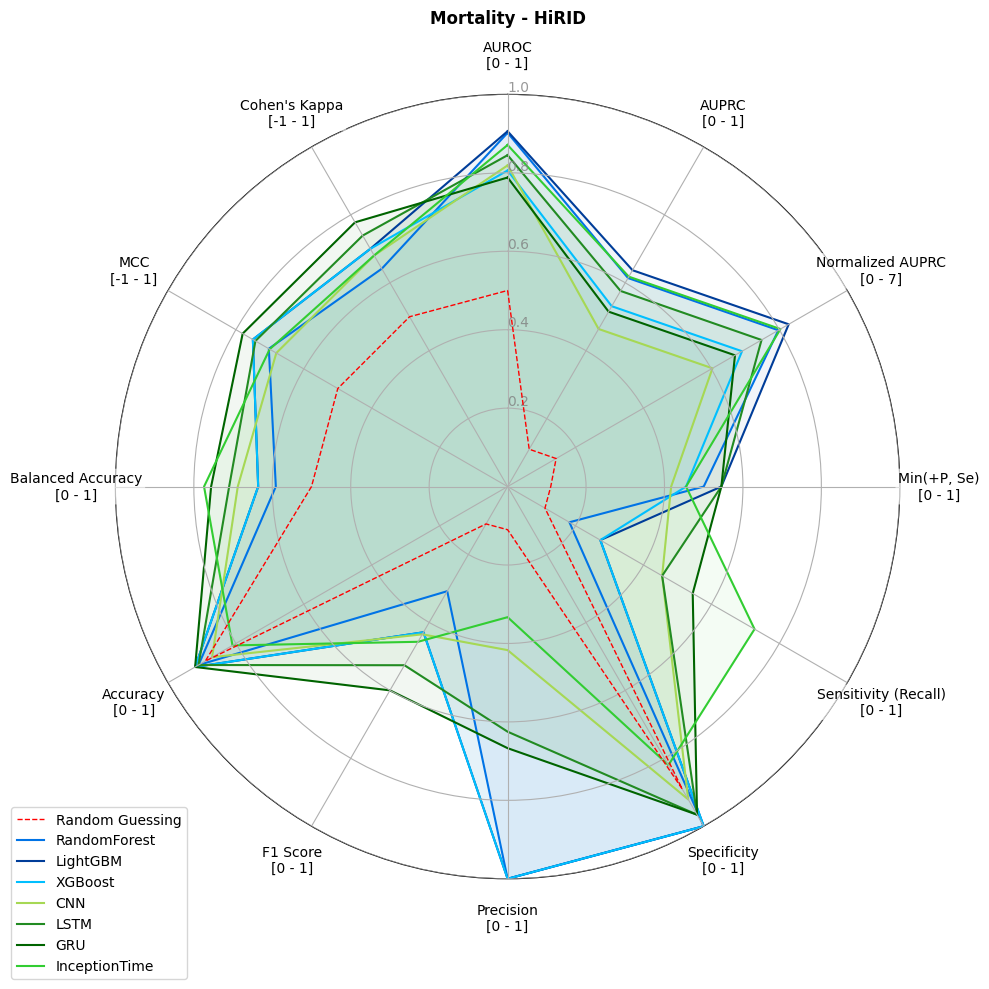

Creating plot for Mortality-MIMIC-IV


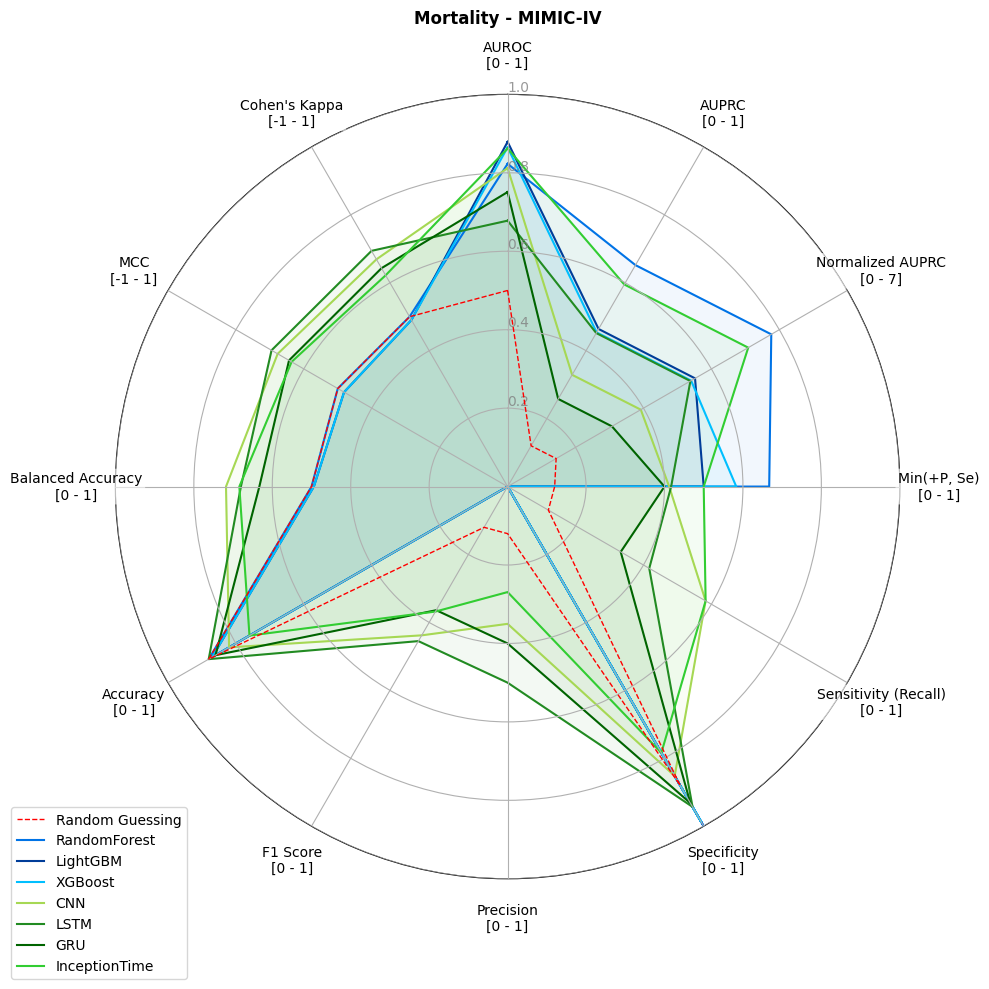

Creating plot for Mortality-eICU


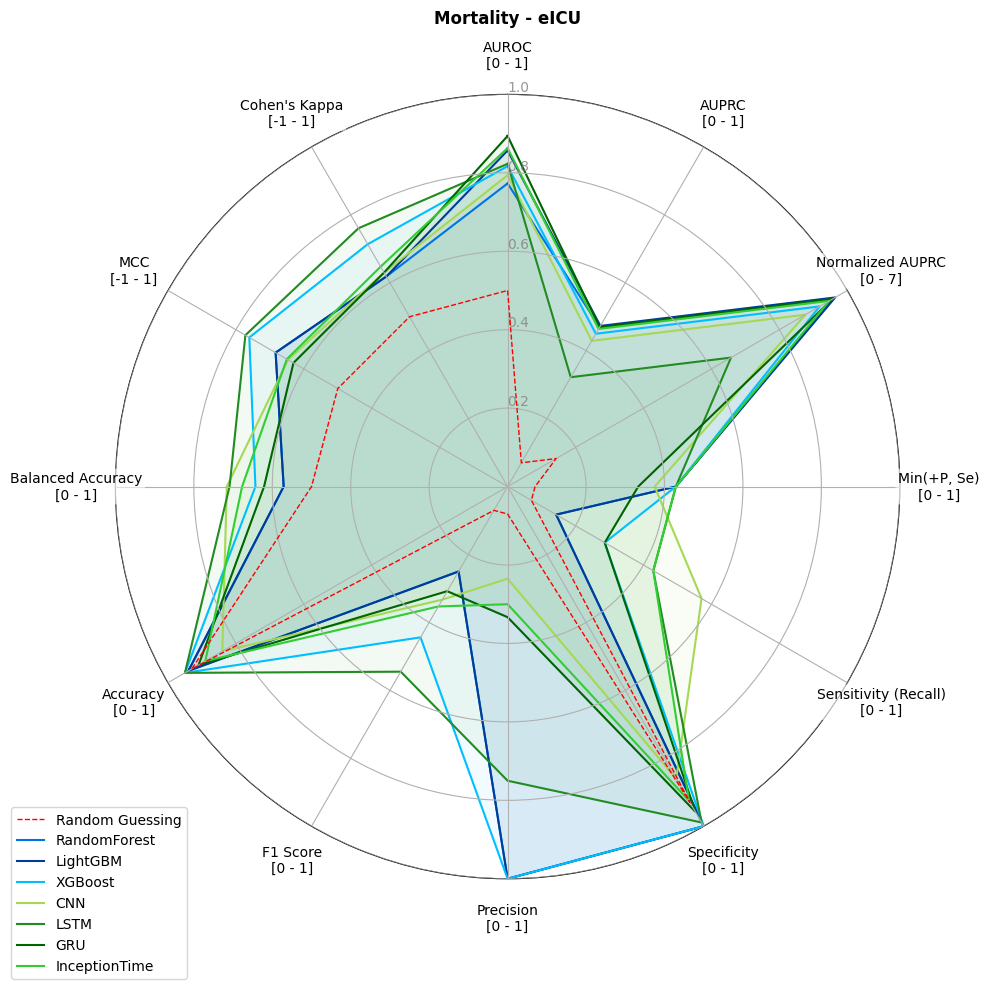

Creating plot for AKI-HiRID


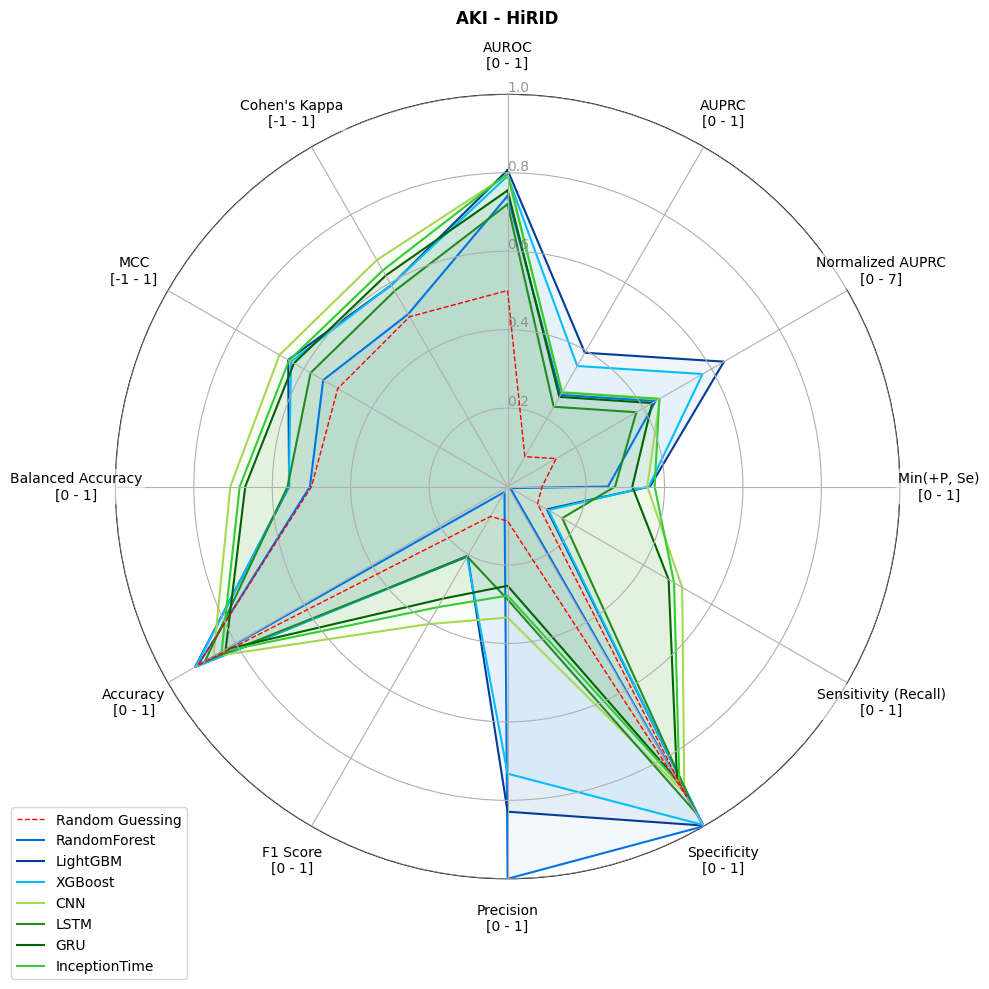

Creating plot for AKI-MIMIC-IV


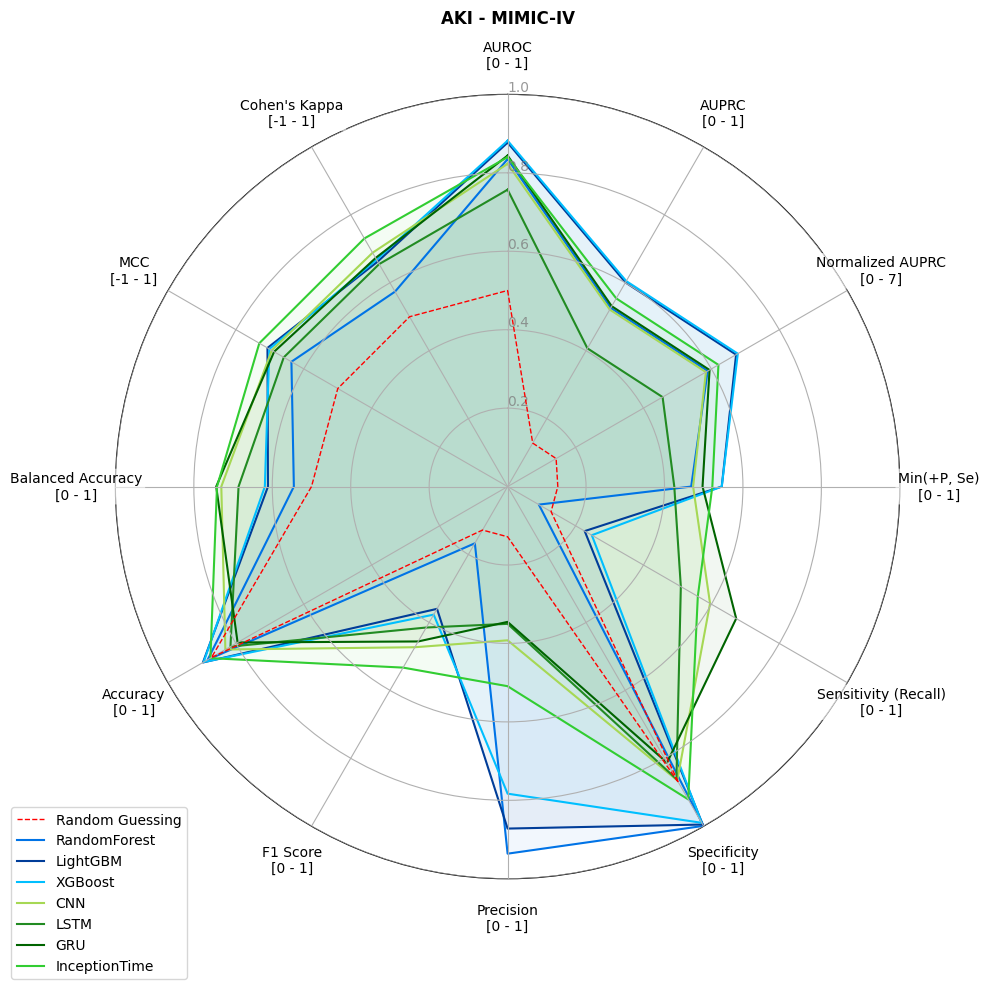

Creating plot for AKI-eICU


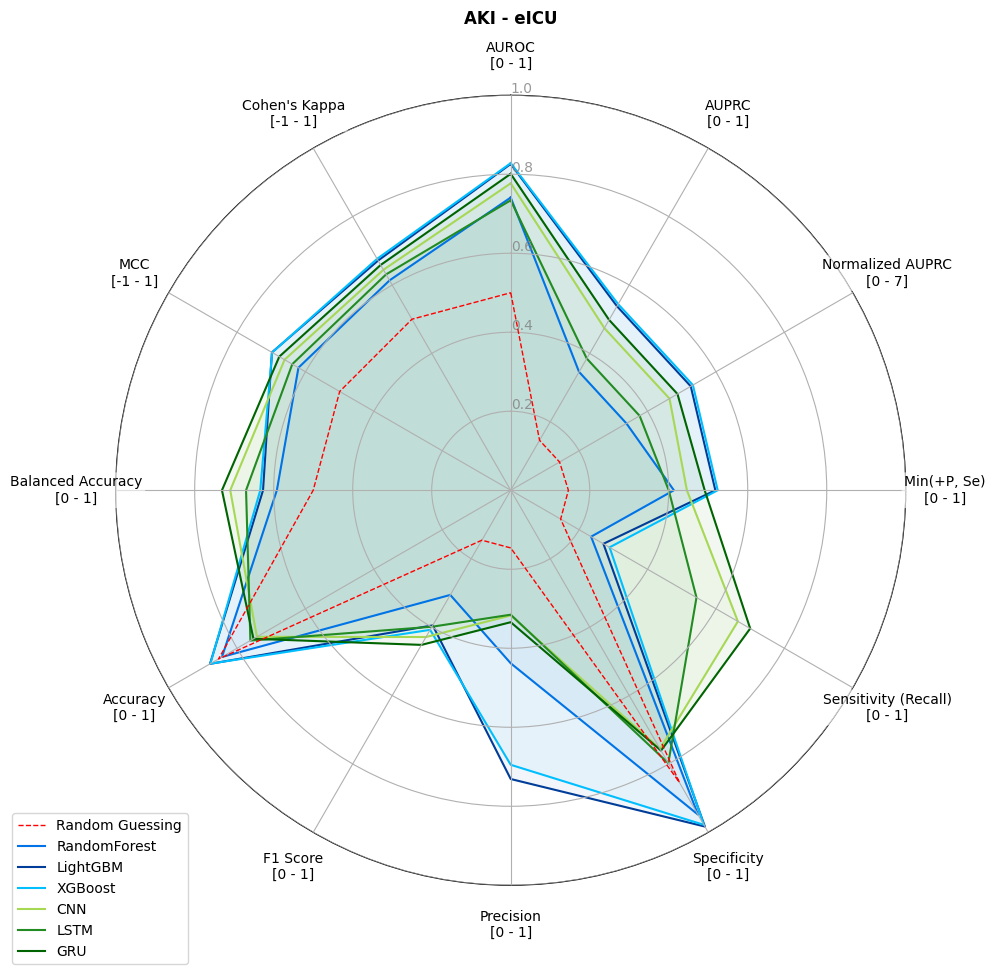

Creating plot for Sepsis-HiRID


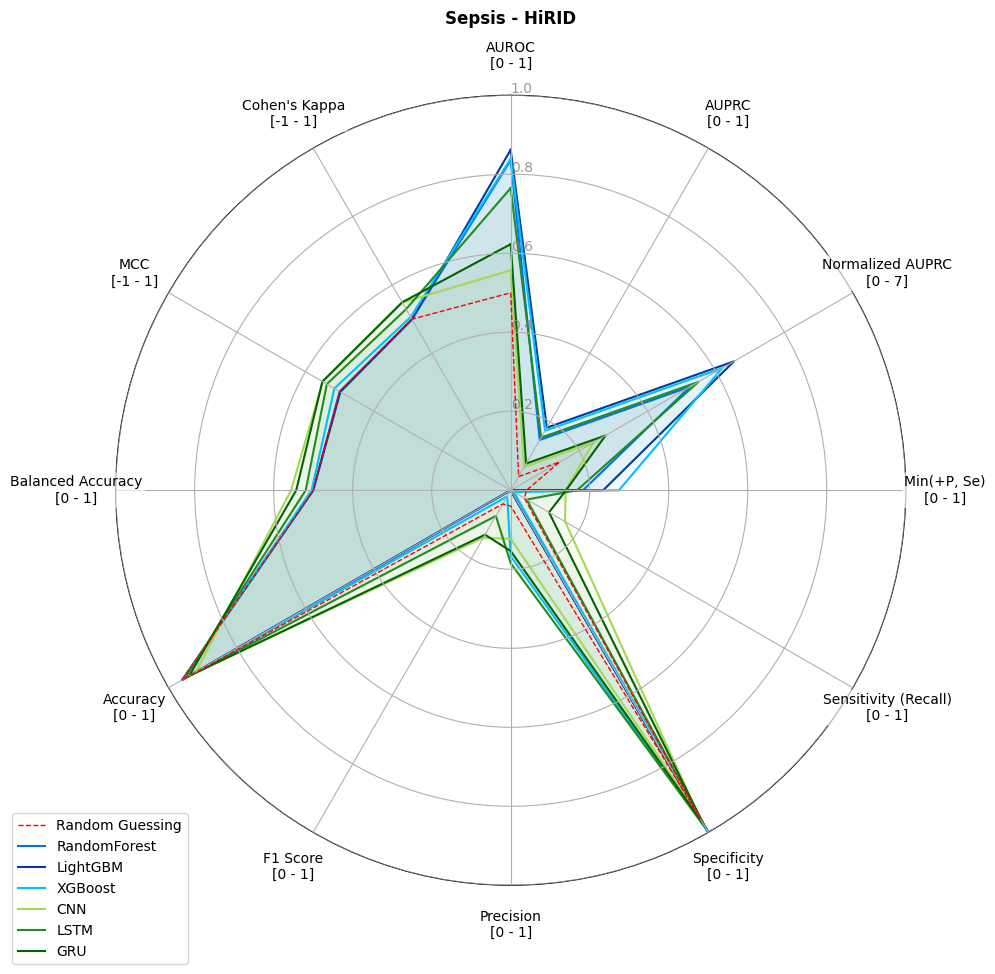

Creating plot for Sepsis-MIMIC-IV


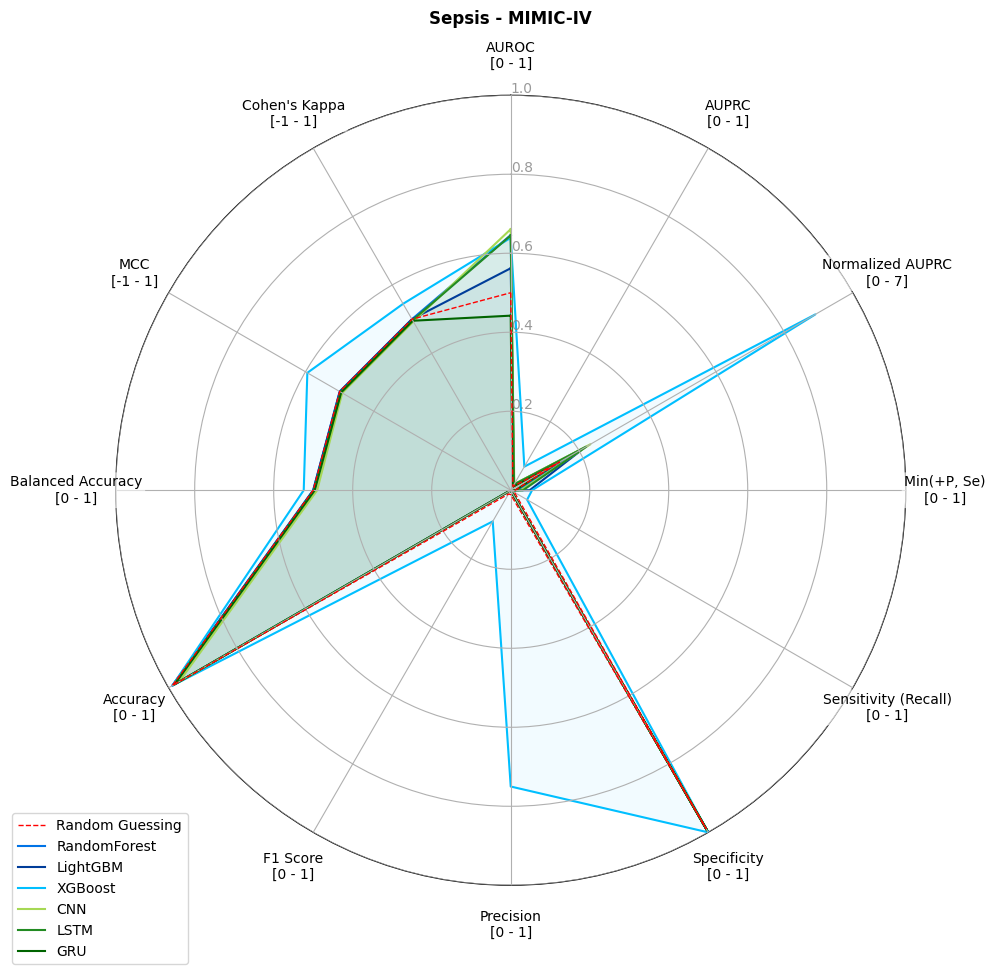

Creating plot for Sepsis-eICU


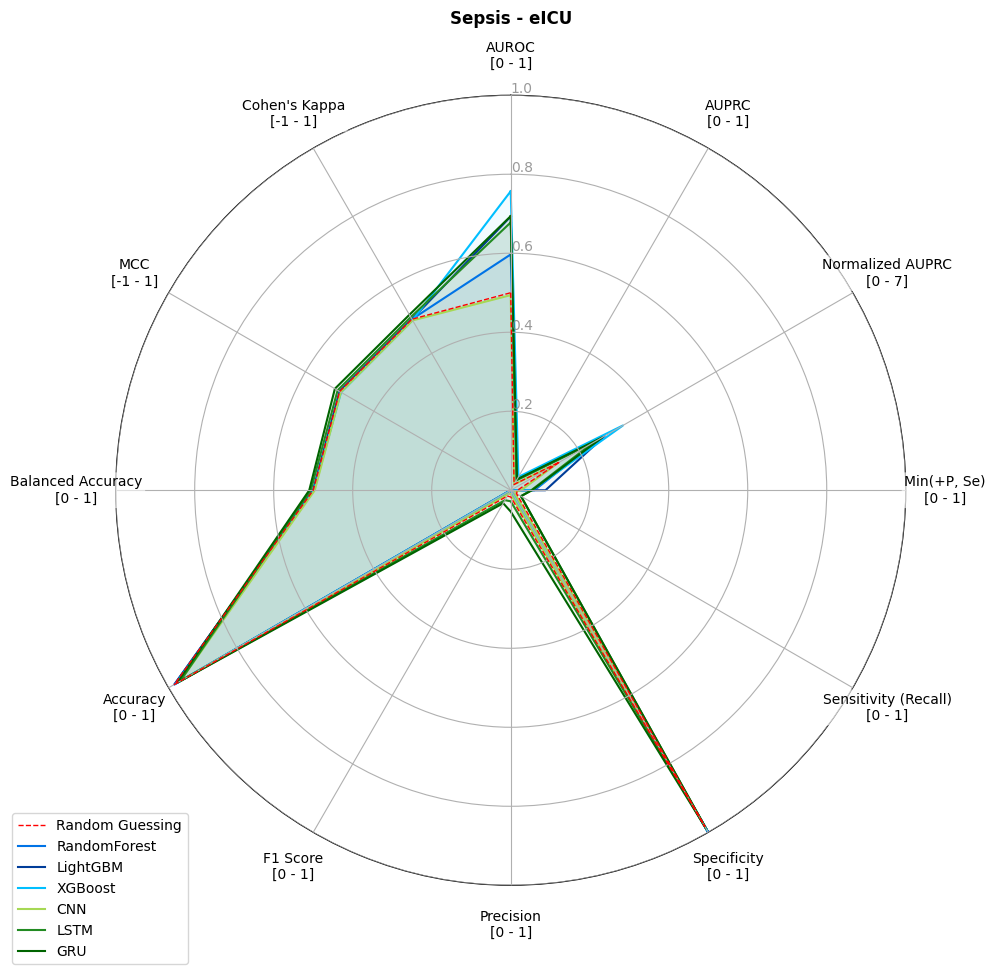

In [5]:
# Get unique tasks, datasets, and models
tasks = df["Task"].unique()
datasets = df["Dataset"].unique()
models = df["Model"].unique()

# Use a writable directory in the user's home folder
output_dir = os.path.join(os.getcwd(), 'radar_charts')
os.makedirs(output_dir, exist_ok=True)

# Generate individual plots for each task-dataset combination
for task in tasks:
    for dataset in datasets:
        # Check if this combination exists in the data
        if len(df[(df['Task'] == task) & (df['Dataset'] == dataset)]) > 0:
            print(f"Creating plot for {task}-{dataset}")
            fig, ax = radar_chart(
                task=task,
                dataset=dataset,
                data=df,
                save_path=f"{output_dir}/{task}_{dataset}_radar_chart.png"
            )
            plt.tight_layout()
            plt.show()
        else:
            print(f"No data found for {task}-{dataset}")

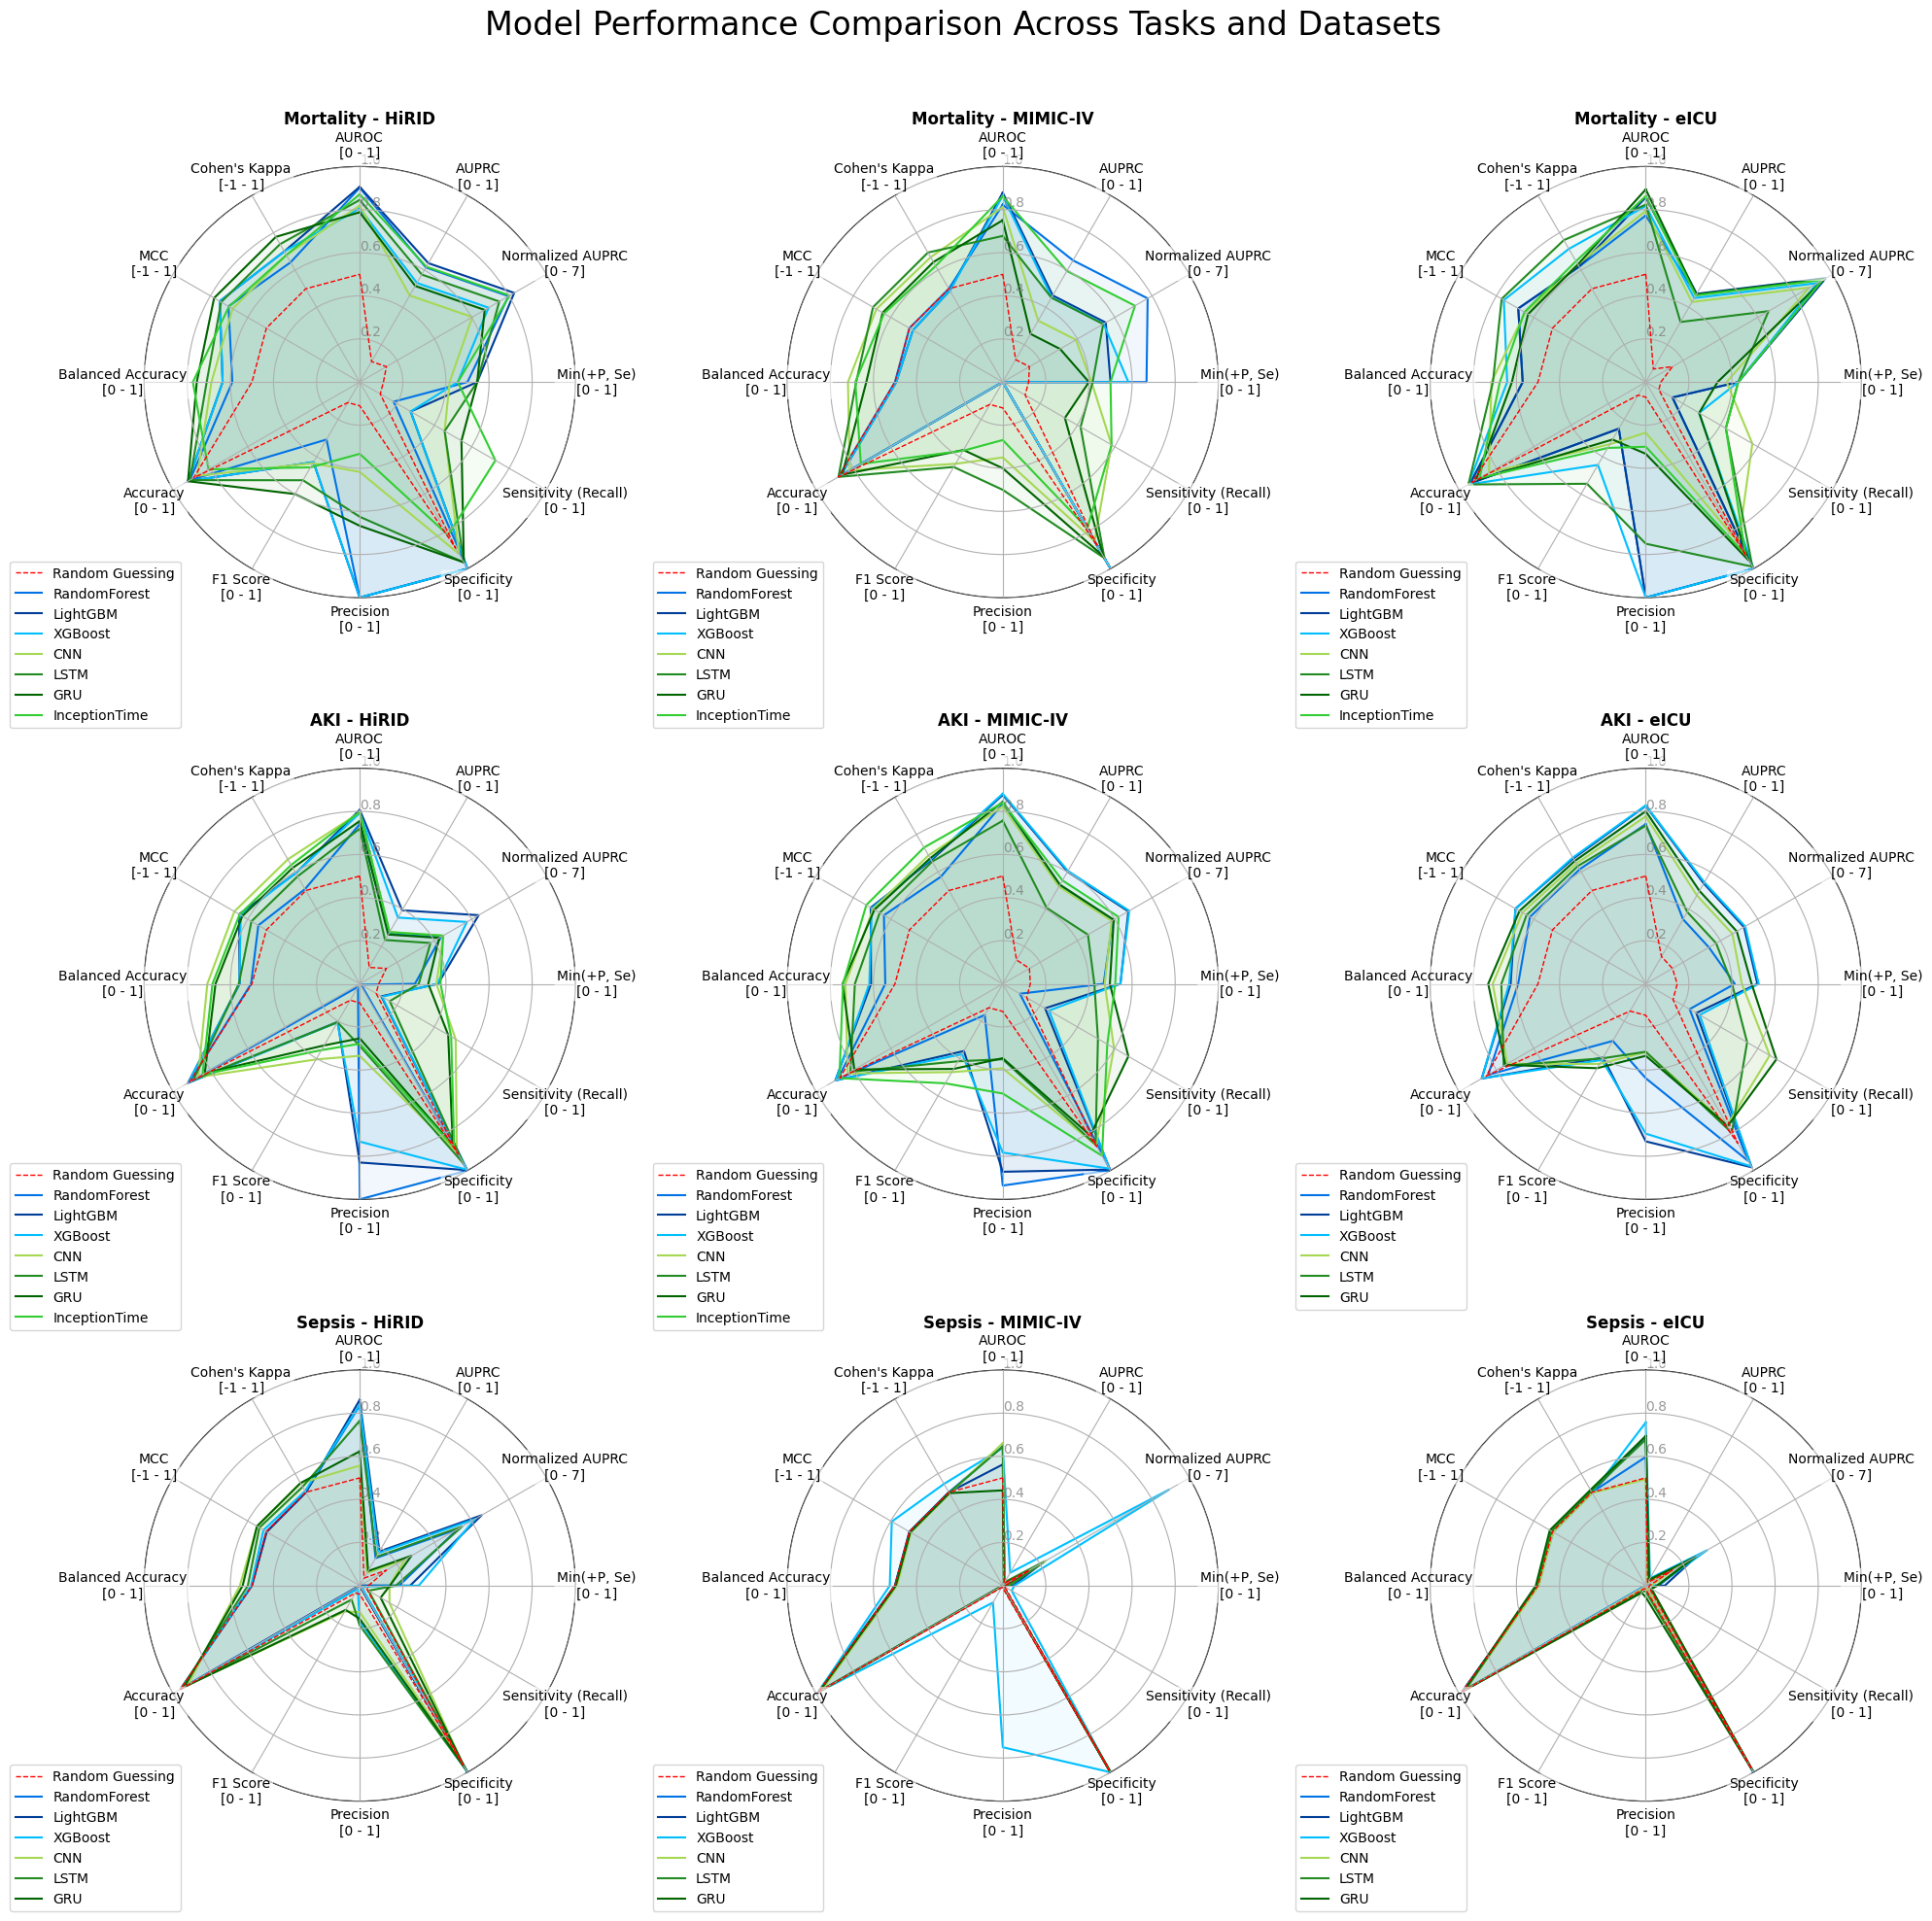

In [6]:
# Display and Export Results
# Create a combined figure with all plots for easy comparison
fig, axes = plt.subplots(3, 3, figsize=(20, 20), subplot_kw=dict(polar=True))
fig.suptitle("Model Performance Comparison Across Tasks and Datasets", fontsize=24)
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.95)

# Flatten axes array for easier iteration
if len(tasks) * len(datasets) > 1:
    axes_flat = axes.flatten()
else:
    axes_flat = [axes]

# Create task and dataset combinations
combinations = []
for task in tasks:
    for dataset in datasets:
        combinations.append((task, dataset))

# Plot each combination
for i, (task, dataset) in enumerate(combinations):
    if i < len(axes_flat):  # We only have space for len(axes_flat) plots
        # Check if this combination exists in the data
        if len(df[(df['Task'] == task) & (df['Dataset'] == dataset)]) > 0:
            # Create the radar chart on the current subplot
            radar_chart(
                task=task,
                dataset=dataset,
                data=df,
                ax=axes_flat[i]
            )
        else:
            axes_flat[i].text(0.5, 0.5, f'No data for {task}-{dataset}', 
                              ha='center', va='center', transform=axes_flat[i].transAxes)

# Hide any unused subplots
for i in range(len(combinations), len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout but leave room for suptitle
plt.savefig(f"{output_dir}/combined_radar_chart.png", dpi=300, bbox_inches='tight')
plt.show()

## Analysis of Spider Plot Results

The spider plots above provide a visual comparison of different models' performance across various tasks and datasets. Here are some observations:

1. **Model Strengths**: Different models show strengths in different metrics. For example, some models may excel in AUROC while others perform better in F1 Score or Balanced Accuracy.

2. **Task Differences**: The prediction tasks (mortality, AKI, sepsis) show different patterns of model performance, reflecting the varying difficulty of each task.

3. **Dataset Impact**: The same model architecture can perform quite differently across datasets, highlighting the importance of data characteristics in model performance.

4. **Balanced Performance**: Models with more uniform coverage of the radar area generally have more balanced performance across different metrics, which might be preferable in clinical settings.

5. **Areas for Improvement**: Metrics where most models perform poorly indicate challenging aspects of the prediction tasks that might benefit from specialized approaches.

These visualizations help in model selection by providing a comprehensive view of performance across multiple dimensions simultaneously, allowing for better-informed decisions when deploying models in clinical settings.